<a href="https://colab.research.google.com/github/junya17/Content-Based-Filtering/blob/main/Content_Based_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 書籍のレコメンドシステム

このノートブックでは、本の推薦システムを構築します。主なステップは以下の通りです：


1.  データ準備：本のデータセットを作成し、必要な情報（タイトル、著者、ジャンル）を含めます。
2.  特徴抽出:ジャンルと著者の情報を結合し、TF-IDFベクトル化を行います。
1.  類似度計算：コサイン類似度を使用して、各本間の類似性を計算します。
2.  推薦関数：特定の本に基づいて他の本を推薦する関数を定義します。
1.  書籍の追加：新しく入荷された本にも同じ処理をする









In [1]:
# pandasライブラリをインポート
# pandasはデータ分析やデータ操作に広く使われるPythonライブラリです。
import pandas as pd

# scikit-learnライブラリからTfidfVectorizerとlinear_kernelをインポート
# TfidfVectorizerはテキストデータをTF-IDF値に変換するために使用されます。
# linear_kernelはベクトル間の類似度を計算する際に使われます。
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 本に関するデータセットを作成
# ここでDataFrameオブジェクトを作成し、本のID、タイトル、著者、ジャンル、ページ数を含む列を定義しています。
books_df = pd.DataFrame({
    'BookID': [1, 2, 3, 4, 5], # 各本のID
    'Title': ['Harry Potter', 'Lord of the Rings', 'Game of Thrones', 'To Kill a Mockingbird', '1984'], # 本のタイトル
    'Author': ['J.K. Rowling', 'J.R.R. Tolkien', 'George R.R. Martin', 'Harper Lee', 'George Orwell'], # 本の著者
    'Genre': ['Fantasy', 'Fantasy', 'Fantasy', 'Classic', 'Classic'], # 本のジャンル
    'Pages': [500, 700, 600, 400, 300] # 本のページ数
})


In [2]:
#タイトルを表示
books_df['Title']

0             Harry Potter
1        Lord of the Rings
2          Game of Thrones
3    To Kill a Mockingbird
4                     1984
Name: Title, dtype: object

In [3]:
# 作成したデータフレーム books_df を表示します。
# このデータフレームには、BookID、Title、Author、Genre、Pagesの各列が含まれており、
# それぞれの本に関する情報が格納されています。
books_df

,BookID,Title,Author,Genre,Pages
0,1,Harry Potter,J.K. Rowling,Fantasy,500
1,2,Lord of the Rings,J.R.R. Tolkien,Fantasy,700
2,3,Game of Thrones,George R.R. Martin,Fantasy,600
3,4,To Kill a Mockingbird,Harper Lee,Classic,400
4,5,1984,George Orwell,Classic,300


In [4]:
# 'Genre'（ジャンル）と 'Author'（著者）の列を結合して、新しい 'Features' 列を作成します。
# この新しい列は、後のTF-IDFベクトル化のために使用されます。
books_df['Features'] = books_df['Genre'] + " " + books_df['Author']

# TfidfVectorizerを初期化します。これはテキストをTF-IDF特徴ベクトルに変換するために使われます。
# 'stop_words' パラメーターに 'english' を指定して、英語の一般的な単語（a, the, andなど）を除外します。
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# 'Features' 列を使用してTF-IDFベクトル化を実行します。
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['Features'])


In [5]:
# TF-IDF行列を密なNumPy配列に変換して表示します。
tfidf_matrix.toarray()

array([[0.        , 0.55645052, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.83088075, 0.        ],
       [0.        , 0.55645052, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.83088075],
       [0.        , 0.4622077 , 0.55681615, 0.        , 0.        ,
        0.69015927, 0.        , 0.        , 0.        ],
       [0.49552379, 0.        , 0.        , 0.61418897, 0.61418897,
        0.        , 0.        , 0.        , 0.        ],
       [0.53177225, 0.        , 0.53177225, 0.        , 0.        ,
        0.        , 0.659118  , 0.        , 0.        ]])

In [6]:
# 'Features' 列の内容を表示します。
books_df['Features']

0          Fantasy J.K. Rowling
1        Fantasy J.R.R. Tolkien
2    Fantasy George R.R. Martin
3            Classic Harper Lee
4         Classic George Orwell
Name: Features, dtype: object

In [7]:
# TfidfVectorizerオブジェクトの情報を表示します。
tfidf_vectorizer

TfidfVectorizer(stop_words='english')

In [8]:
# スパースなTF-IDF行列の構造を表示します。
print(tfidf_matrix)

  (0, 7)	0.830880748357988
  (0, 1)	0.5564505207186617
  (1, 8)	0.830880748357988
  (1, 1)	0.5564505207186617
  (2, 5)	0.6901592662889631
  (2, 2)	0.5568161504458247
  (2, 1)	0.46220770413113277
  (3, 4)	0.6141889663426562
  (3, 3)	0.6141889663426562
  (3, 0)	0.49552379079705045
  (4, 6)	0.6591180018251053
  (4, 0)	0.5317722537280788
  (4, 2)	0.5317722537280788


In [9]:
# コサイン類似度を計算します。これは、各本間の類似度を測定するために使用されます。
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [10]:
# 計算されたコサイン類似度を表示します。
print(cosine_sim)

[[1.         0.30963718 0.25719572 0.         0.        ]
 [0.30963718 1.         0.25719572 0.         0.        ]
 [0.25719572 0.25719572 1.         0.         0.29609938]
 [0.         0.         0.         1.         0.2635058 ]
 [0.         0.         0.29609938 0.2635058  1.        ]]


In [12]:
# 特定の本に基づいておすすめの本を提供する関数を定義します。
def recommend(title):
    # 指定されたタイトルに一致する本のインデックスを取得します。
    idx = books_df.loc[books_df['Title'] == title].index[0]
    print(idx)

    # 指定された本に対するすべての本の類似度スコアを取得します。
    sim_scores = list(enumerate(cosine_sim[idx]))
    print(sim_scores)

    # 類似度スコアを降順に並び替えます。
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 最も類似度が高い上位3つの本を選択します（最初の要素は自分自身なので除外します）。
    sim_scores = sim_scores[1:4]

    # 選択された本のインデックスを取得します。
    book_indices = [i[0] for i in sim_scores]

    # 選択された本のタイトルを返します。
    return books_df['Title'].iloc[book_indices]

# 'Harry Potter'に基づいたおすすめの本を表示します。
print(recommend('Harry Potter'))

0
[(0, 0.9999999999999999), (1, 0.3096371820080698), (2, 0.257195717643946), (3, 0.0), (4, 0.0)]
1        Lord of the Rings
2          Game of Thrones
3    To Kill a Mockingbird
Name: Title, dtype: object


## TF-IDFベクトルの視覚化

下の図は各本の特徴を示している。Harry PotterとLord of the Ringsは近く、1984などは遠い。
ユーザーにレコメンドする場合は特徴が近いものを勧める。




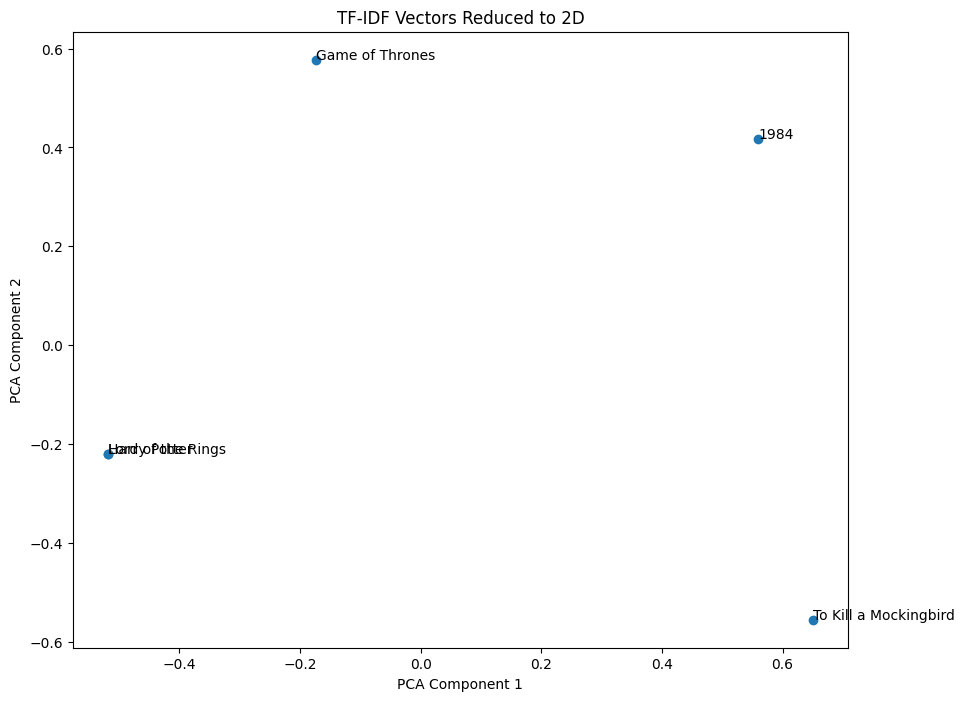

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# TF-IDFベクトルを2次元に削減
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
reduced_tfidf

# 2次元プロット
plt.figure(figsize=(10, 8))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1])
for i, title in enumerate(books_df['Title']):
    plt.text(reduced_tfidf[i, 0], reduced_tfidf[i, 1], title)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Reduced to 2D')
plt.show()


## コサイン類似度行列のヒートマップ
赤は数字が高いほど関連度が高い。


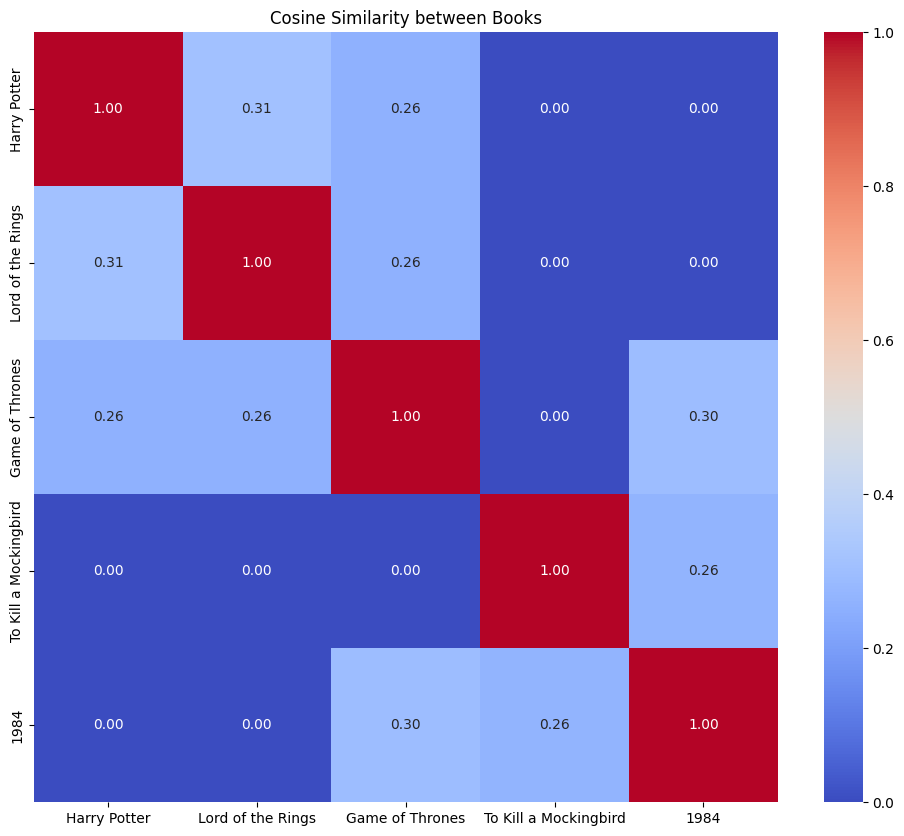

In [14]:
import seaborn as sns

# コサイン類似度のヒートマップ
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_sim, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=books_df['Title'], yticklabels=books_df['Title'])
plt.title('Cosine Similarity between Books')
plt.show()


## バーチャートの作成
本の類似度スコア : Load of the Rignsが関連度が高いのがわかる。

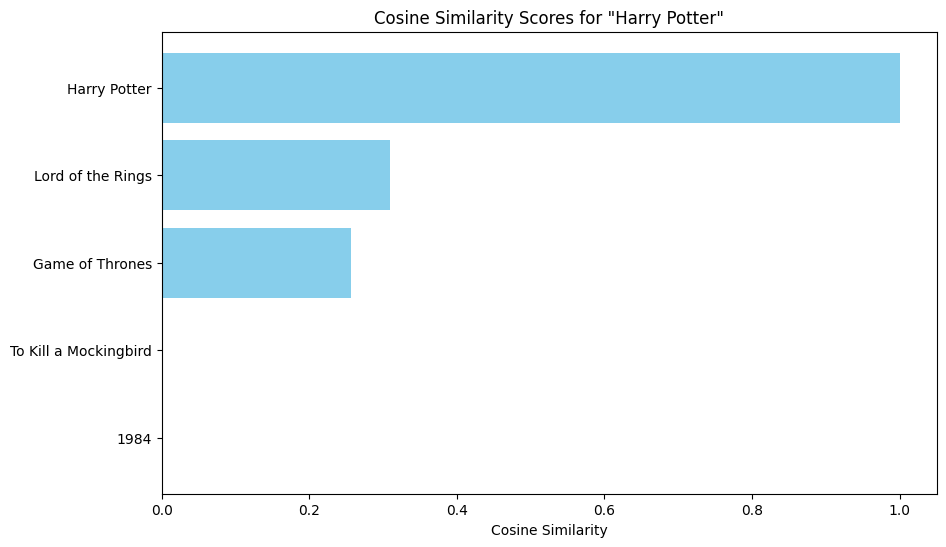

In [15]:
import numpy as np

# 'Harry Potter'に対する各本の類似度スコアを取得
hp_index = books_df[books_df['Title'] == 'Harry Potter'].index[0]
scores = cosine_sim[hp_index] # cosine_simを使う

# バーチャートを表示
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(scores)), scores, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.yticks(np.arange(len(scores)), books_df['Title'])
plt.title('Cosine Similarity Scores for "Harry Potter"')
plt.gca().invert_yaxis()
plt.show()

## 新しい商品が入ってきた場合。
'The Chronicles of Narnia'が入荷されてきて、ユーザーへレコメンドする

In [16]:
# 新しい本をデータセットに追加
new_book = {'BookID': 6, 'Title': 'The Chronicles of Narnia', 'Author': 'C.S. Lewis', 'Genre': 'Fantasy', 'Pages': 768}
books_df = books_df.append(new_book, ignore_index=True)
books_df

<ipython-input-16-e4b56011e62b>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  books_df = books_df.append(new_book, ignore_index=True)


,BookID,Title,Author,Genre,Pages,Features
0,1,Harry Potter,J.K. Rowling,Fantasy,500,Fantasy J.K. Rowling
1,2,Lord of the Rings,J.R.R. Tolkien,Fantasy,700,Fantasy J.R.R. Tolkien
2,3,Game of Thrones,George R.R. Martin,Fantasy,600,Fantasy George R.R. Martin
3,4,To Kill a Mockingbird,Harper Lee,Classic,400,Classic Harper Lee
4,5,1984,George Orwell,Classic,300,Classic George Orwell
5,6,The Chronicles of Narnia,C.S. Lewis,Fantasy,768,NaN


In [17]:
# 'Features' 列を更新
books_df['Features'] = books_df['Genre'] + " " + books_df['Author']

In [18]:
books_df

,BookID,Title,Author,Genre,Pages,Features
0,1,Harry Potter,J.K. Rowling,Fantasy,500,Fantasy J.K. Rowling
1,2,Lord of the Rings,J.R.R. Tolkien,Fantasy,700,Fantasy J.R.R. Tolkien
2,3,Game of Thrones,George R.R. Martin,Fantasy,600,Fantasy George R.R. Martin
3,4,To Kill a Mockingbird,Harper Lee,Classic,400,Classic Harper Lee
4,5,1984,George Orwell,Classic,300,Classic George Orwell
5,6,The Chronicles of Narnia,C.S. Lewis,Fantasy,768,Fantasy C.S. Lewis


In [19]:
# TF-IDFベクトルを更新
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['Features'])

In [20]:
books_df['Title']

0                Harry Potter
1           Lord of the Rings
2             Game of Thrones
3       To Kill a Mockingbird
4                        1984
5    The Chronicles of Narnia
Name: Title, dtype: object

## TF-IDFベクトルの視覚化

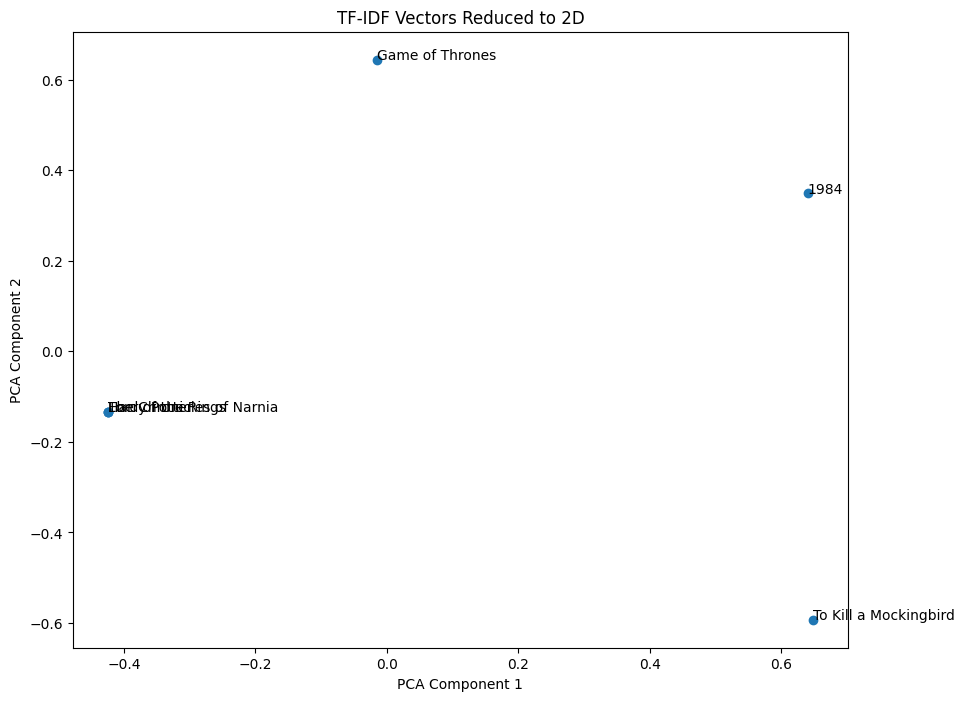

In [21]:
# TF-IDFベクトルを2次元に削減
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
reduced_tfidf

# 2次元プロット
plt.figure(figsize=(10, 8))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1])
for i, title in enumerate(books_df['Title']):
    plt.text(reduced_tfidf[i, 0], reduced_tfidf[i, 1], title)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Reduced to 2D')
plt.show()

In [22]:
# コサイン類似度を計算します。これは、各本間の類似度を測定するために使用されます。
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# バーチャートの作成

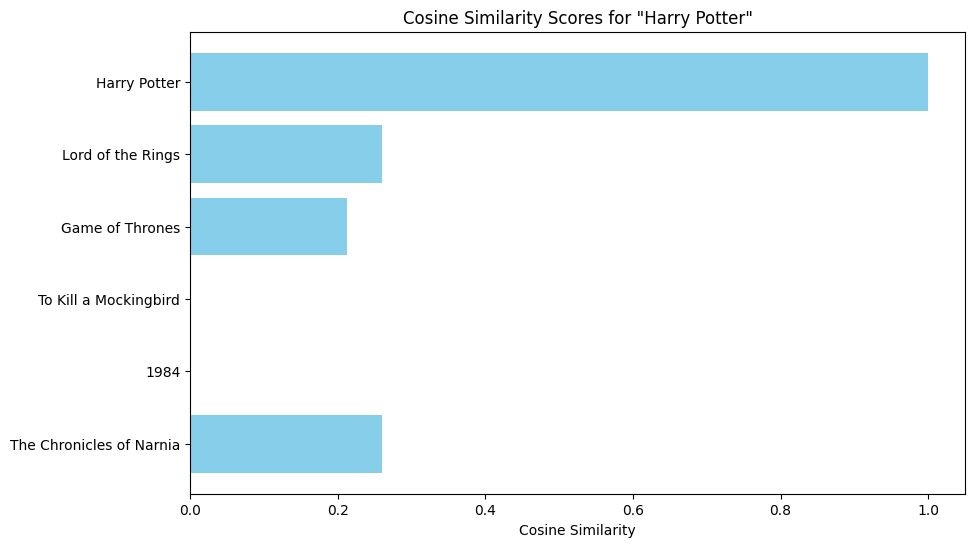

In [23]:
# 'Harry Potter'に対する各本の類似度スコアを取得
hp_index = books_df[books_df['Title'] == 'Harry Potter'].index[0]
scores = cosine_sim[hp_index] # cosine_simを使う

# バーチャートを表示
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(scores)), scores, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.yticks(np.arange(len(scores)), books_df['Title'])
plt.title('Cosine Similarity Scores for "Harry Potter"')
plt.gca().invert_yaxis()
plt.show()

In [24]:
# ハリー・ポッターに類似した本を探す
recommendations = recommend('Harry Potter')
recommendations

0
[(0, 0.9999999999999998), (1, 0.2603311847071736), (2, 0.2127460642596172), (3, 0.0), (4, 0.0), (5, 0.2603311847071736)]


1           Lord of the Rings
5    The Chronicles of Narnia
2             Game of Thrones
Name: Title, dtype: object

新しく入荷されたThe Chronicles of Narniaは推薦の2番目に入るということになります